## Setup

In [29]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

cwd = os.getcwd()
drive_path = os.path.join(cwd, 'drive')
my_drive_path = os.path.join(drive_path, 'My Drive')

project_path = os.path.join(my_drive_path, 'AN2DL-Project')
data_path = os.path.join(project_path, 'data')
train_path = os.path.join(data_path, 'Training')
test_path = os.path.join(data_path, 'Test_Dev')
logs_path = os.path.join(project_path, 'logs')
results_path = os.path.join(project_path, 'results')

X_dir = 'Images'
Y_dir = 'Masks'

teams = ['Bipbip','Pead','Roseau','Weedelec']
crops = ['Haricot','Mais']

train_imgs_path = os.path.join(train_path, 'training.txt')
valid_imgs_path = os.path.join(train_path, 'validation.txt')

In [30]:
from google.colab import drive
drive.mount(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Preprocessing

In [ ]:
# Splitting all data in train/valid on random teams and crops

train_imgs_stream = open(train_imgs_path, 'w')
valid_imgs_stream = open(valid_imgs_path, 'w')

for team in teams:
  for crop in crops:
    curr_imgs = []

    for root,dirs,files in os.walk(os.path.join(train_path, team, crop, X_dir)):
      print("Found {} images for team {}, crop {}".format(len(files),team,crop))
      for file in files:
        curr_imgs.append(os.path.splitext(file)[0])

    np.random.shuffle(curr_imgs)
    curr_valid = curr_imgs[:18]
    curr_train = curr_imgs[18:]

    for t in curr_train:
      train_imgs_stream.write("{} {} {}\n".format(team, crop, t))
    for v in curr_valid:
      valid_imgs_stream.write("{} {} {}\n".format(team, crop, v))

train_imgs_stream.close()
valid_imgs_stream.close()

Found 90 images for team Bipbip, crop Haricot
Found 90 images for team Bipbip, crop Mais
Found 90 images for team Pead, crop Haricot
Found 90 images for team Pead, crop Mais
Found 90 images for team Roseau, crop Haricot
Found 90 images for team Roseau, crop Mais
Found 90 images for team Weedelec, crop Haricot
Found 90 images for team Weedelec, crop Mais


In [3]:
img_h = 256
img_w = 256

num_channels = 3
num_classes = 3

batch_size = 4

def rgb_to_target_mask(mask_rgb):
    mask_arr = np.array(mask_rgb)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

def target_to_rgb_mask(mask_arr):
    mask_arr = np.squeeze(mask_arr)

    new_mask_rgb = np.zeros((*mask_arr.shape[:2],num_channels), dtype=mask_arr.dtype)

    new_mask_rgb[np.where(mask_arr == 0)] = [0, 0, 0]
    new_mask_rgb[np.where(mask_arr == 1)] = [255, 255, 255]
    new_mask_rgb[np.where(mask_arr == 2)] = [216, 67, 82]

    return new_mask_rgb

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=3,
                                      height_shift_range=3,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
mask_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=3,
                                      height_shift_range=3,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')

**Function for training and validation image tilings**

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np




def start_points(size, split_size, overlap=0.1):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points

def tile_image(img, split_width=256,split_height=256, overlap=0):

    
    img_width, img_height = (1200,700)

    X_points = start_points(img_width, split_width, overlap)
    Y_points = start_points(img_height, split_height, overlap)

    img_arr = np.array(img)

    count = 0

    img_tiles = []
    for i in Y_points:
        for j in X_points:
            split = img_arr[i:i+split_height, j:j+split_width]
            img_tiles.append(split)
            #plt.imshow(split)
            #plt.show()

            count += 1
    return np.asarray(img_tiles)

def reconstruct_image(img_tiles,img_height,img_width,split_height,split_width,overlap=0):

    img_array = np.full((img_height, img_width,3), -1)


    X_points = start_points(img_width, split_width, overlap)
    Y_points = start_points(img_height, split_height, overlap)

    col_img = len(X_points)
    row_img = len(Y_points)

    for j in range(len(img_tiles)):
      num_row = int(np.floor(j / col_img))
      num_col = int(j % col_img)
      pos_v = Y_points[num_row]
      pos_h = X_points[num_col]
      h_tile, w_tile, _ = img_tiles[j].shape

      for k in range(h_tile):
        for l in range(w_tile):
          if np.array_equal(img_array[k+pos_v][l+pos_h], np.array([-1,-1,-1])):
            img_array[k+pos_v][l+pos_h] = img_tiles[j][k][l]
          else:
            img_array[k+pos_v][l+pos_h] = np.add(img_array[k+pos_v][l+pos_h],img_tiles[j][k][l])/2

    return img_array


In [7]:
from PIL import Image
#tf.python.keras.utils.data_utils.Sequence
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self, out_shape, which_subset, preprocessing_function=None):
    self.out_shape = out_shape

    if which_subset == 'training':
      subset_file = train_imgs_path
    elif which_subset == 'validation':
      subset_file = valid_imgs_path
    
    with open(subset_file, 'r') as f:
      subset_data = f.readlines()
    
    #print(subset_data)

    self.which_subset = which_subset
    self.subset_data = subset_data
    self.preprocessing_function = preprocessing_function

  def __len__(self):
    return len(self.subset_data)

  def __getitem__(self, index):
    team, crop, name = self.subset_data[index].split()
    if team == teams[2]:
      img = Image.open(os.path.join(train_path, team, crop, X_dir, name + '.png'))
    else:
      img = Image.open(os.path.join(train_path, team, crop, X_dir, name + '.jpg'))
    mask = Image.open(os.path.join(train_path, team, crop, Y_dir, name + '.png'))

    img.resize((1200,700))
    mask.resize((1200,700),resample=Image.NEAREST)
    tiles_img = tile_image(img,self.out_shape[1],self.out_shape[0],0.2)
    tiles_mask = tile_image(mask,self.out_shape[1],self.out_shape[0],0.2)

    
    img_arr = np.array(tiles_img)
    mask_arr = np.array(tiles_mask)
    
    if self.preprocessing_function is not None:
      img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.expand_dims([rgb_to_target_mask(mask_arra) for mask_arra in mask_arr],axis=-1)

(15, 256, 256, 3)


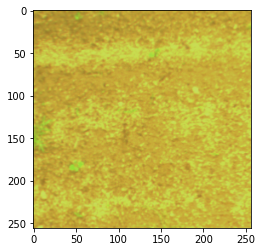

In [ ]:
from PIL import Image
imge = Image.open(os.path.join(train_path, 'Roseau','Mais','Images','Roseau_mais_0330_false.png'))
imge_width, imge_height = imge.size
img_tilings =tile_image(imge)
print(img_tilings.shape)
plt.imshow(img_tilings[0])
plt.show()


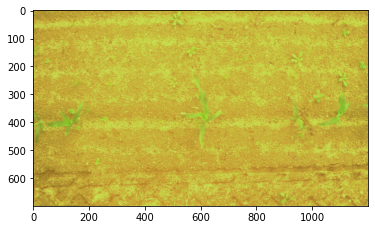

In [ ]:
imgrec = reconstruct_image(img_tilings,700,1200,256,256,overlap=0)
plt.imshow(imgrec)
plt.show()


In [ ]:
!ls /content/

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

training_dataset = CustomDataset((img_h,img_w), 'training',
                        preprocessing_function=None)
validation_dataset = CustomDataset((img_h,img_w), 'validation',
                              preprocessing_function=None)

print("Found {} images for training".format(len(training_dataset)))
print("Found {} images for validation".format(len(validation_dataset)))


Found 576 images for training
Found 144 images for validation


576
(24, 256, 256, 3)


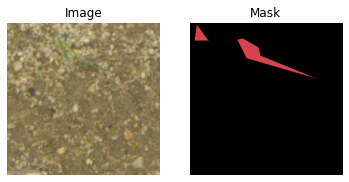

In [ ]:
iterator = iter(training_dataset)

#gen = next(iterator)
print(len(training_dataset))
#print( gen)
img, target = next(iterator)
print(img.shape)
img1 = img[10]
target = target[10]
target = target_to_rgb_mask(target)
#target /= 255.

fig, ax = plt.subplots(1, 2)

ax[0].axis('off')
ax[0].imshow(img1)
ax[0].set_title("Image")
ax[1].axis('off')
ax[1].imshow(target)
ax[1].set_title("Mask")

plt.show()


## Model

In [ ]:
  
from keras.models import Model
from keras.layers import Input, Cropping2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam


def get_unet():
    inputs = Input((img_h, img_w, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])



    return model

#The different layers in our neural network model (including convolutions, maxpooling and upsampling)

In [ ]:
model = get_unet()
model .summary()

## Learning

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/AN2DL-Project/logs

In [11]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

def meanIoU(y_true, y_pred):
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)
    per_class_iou = []

    for i in range(1,num_classes+1):
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)
      
    return tf.reduce_mean(per_class_iou)

metrics = ['accuracy', meanIoU]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
from datetime import datetime

model_name = 'Unet_Based_V1.0'
now = datetime.now().strftime('%b%d_%H-%M-%S')
exp_dir = os.path.join(logs_path, model_name + '_' + str(now))

In [ ]:
callbacks = []

ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 
                                                                        'cp_{epoch:02d}.ckpt'),           
                                                    save_weights_only=True,
                                                    save_best_only=True)
callbacks.append(ckpt_callback)

tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)
callbacks.append(tb_callback)

early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
    callbacks.append(es_callback)

model.fit(x=training_dataset,
          epochs=25,
          steps_per_epoch=len(training_dataset),
          validation_data=validation_dataset,
          validation_steps=len(validation_dataset),
          callbacks=callbacks)

## Test

In [18]:
#ckpt_file = input('Enter checkpoint file name: ')
#model_path = os.path.join(ckpt_dir, ckpt_file)
model_path = os.path.join(logs_path, "Unet_Based_V1.0_Dec13_08-27-18/ckpts/cp_14.ckpt")

model.load_weights(model_path)

In [ ]:
model.summary()

**Function for test images tiling**

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np




def start_points(size, split_size, overlap=0.1):
    points = [0]
    stride = int(split_size * (1-overlap))
    counter = 1
    while True:
        pt = stride * counter
        if pt + split_size >= size:
            points.append(size - split_size)
            break
        else:
            points.append(pt)
        counter += 1
    return points

def _tile_image(img, split_width=256,split_height=256, overlap=0):

    
    img_width, img_height = img.size

    X_points = start_points(img_width, split_width, overlap)
    Y_points = start_points(img_height, split_height, overlap)
    #print(X_points)
    #print(Y_points)
    img_arr = np.array(img)
    #plt.imshow(img_arr)
    #plt.show()
    #print (img_arr.shape)
    count = 0

    img_tiles = []
    for i in Y_points:
        for j in X_points:
            split = img_arr[i:i+split_height, j:j+split_width]
            img_tiles.append(split)
            #plt.imshow(split)
            #plt.show()
            #cv2.imwrite('{}_{}.{}'.format(name, count, frmt), split)
            count += 1
    return np.asarray(img_tiles)

def _reconstruct_image(imga_tiles,img_height,img_width,split_height,split_width,overlap=0):

    img_array = np.full((img_height, img_width,3), -1)

    X_points = start_points(img_width, split_width, overlap)
    Y_points = start_points(img_height, split_height, overlap)

    col_img = len(X_points)
    row_img = len(Y_points)

    for j in range(len(imga_tiles)):
      num_rows = int(np.floor(j / col_img))
      num_cols = int(j % col_img)
      #print(num_cols)
      pos_v = Y_points[num_rows]
      pos_h = X_points[num_cols]
      h_tile, w_tile, _ = imga_tiles[j].shape

      for k in range(h_tile):
        for l in range(w_tile):
          if np.array_equal(img_array[k+pos_v][l+pos_h], np.array([-1,-1,-1])):
            img_array[k+pos_v][l+pos_h] = imga_tiles[j][k][l]
          else:
            img_array[k+pos_v][l+pos_h] = np.add(img_array[k+pos_v][l+pos_h],imga_tiles[j][k][l])/2

    return img_array


(1536, 2048, 3)


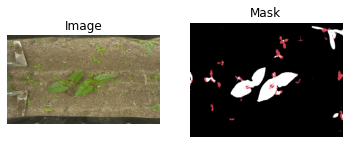

In [27]:
from PIL import Image

def rle_encode(img):
  img = np.array(img)
  pixels = img.flatten()
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  runs[1::2] -= runs[::2]
  return ' '.join(str(x) for x in runs)

img_name = "Bipbip_haricot_im_02781.jpg"
img_path = os.path.join(test_path, "Bipbip", "Haricot", X_dir, img_name)

img = Image.open(img_path).convert('RGB')

_imge_width, _imge_height = img.size
img = img.resize((1200,700))
_img_tilings = _tile_image(img,img_w,img_h,0.2)

mask_arrs =[]
img_prediction=[]

for pr_img in _img_tilings:
  prediction = model.predict(x=tf.expand_dims(pr_img, 0))[0]
  mask_arr = tf.argmax(prediction,-1)
  mask_arr = target_to_rgb_mask(mask_arr)
  mask_arrs.append(mask_arr)

mask_arras = np.asarray(mask_arrs)


target = _reconstruct_image(mask_arras,img.size[1],img.size[0],img_h,img_w,overlap=0.2)

imgg = Image.fromarray(target.astype('uint8'), 'RGB')
imgg = imgg.resize((_imge_width, _imge_height))
target = np.array(imgg)
print(target.shape)
fig, ax = plt.subplots(1, 2)

ax[0].axis('off')
ax[0].imshow(img)
ax[0].set_title("Image")
ax[1].axis('off')
ax[1].imshow(target)
ax[1].set_title("Mask")

plt.show()


In [23]:
print(rle_encode(np.array(rgb_to_target_mask(target) == 2)))

161624 1 165711 7 167754 15 169793 1 169799 18 171836 1 171841 1 171847 13 173886 21 175931 1 175934 21 177921 3 177929 1 177942 1 177947 1 177979 1 177982 21 179971 2 179976 3 179989 1 180027 10 180042 9 182020 15 182037 1 182078 1 182081 1 182093 1 182098 1 184070 13 184085 1 184147 1 184155 1 186118 19 186145 1 186203 1 188167 29 188248 4 190214 31 190296 1 192263 1 192268 24 192344 1 194319 19 194390 4 194395 1 196368 5 196374 12 196438 4 196443 1 198395 1 198407 1 198412 1 198418 1 198424 1 198430 7 198483 6 200442 2 200454 2 200466 1 200481 1 200483 1 200534 3 202479 1 202481 25 202514 1 202532 1 204521 1 204527 1 204530 27 206578 30 206610 1 208623 1 208626 27 210671 30 212719 1 212721 28 214770 27 216818 1 216820 25 218869 24 220917 21 222962 1 222964 20 222991 1 225010 21 225045 1 225048 1 227055 1 227057 23 227087 1 227093 1 227095 2 227105 1 229106 24 229135 1 229141 7 229153 1 231154 50 233190 1 233202 53 235250 53 237286 1 237295 1 237298 54 239343 1 239345 57 241385 65 24

In [28]:
import json

def rle_encode(img):
  img = np.array(img)
  pixels = img.flatten()
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  runs[1::2] -= runs[::2]
  return ' '.join(str(x) for x in runs)

submission_dict = {}

for team in teams:
  for crop in crops:
    for root,dirs,files in os.walk(os.path.join(test_path, team, crop, X_dir)):
      for file in files:
        img_name = os.path.splitext(file)[0]
        if team == teams[2]:
          img_path = os.path.join(test_path, team,crop, X_dir, img_name+".png")
        else:
          img_path = os.path.join(test_path, team,crop, X_dir, img_name+".jpg")

        img = Image.open(img_path).convert('RGB')
        
        _imge_width, _imge_height = img.size
        img = img.resize((1200,700))
        _img_tilings = _tile_image(img,img_w,img_h,0.2)

        mask_arrs =[]
        #img = img.resize((img_h, img_w))
        #img = np.array(img)
        #img = preprocess_input(img)

        for pr_img in _img_tilings:
          prediction = model.predict(x=tf.expand_dims(pr_img, 0))[0]
          mask_arr = tf.argmax(prediction,-1)
          mask_arr = target_to_rgb_mask(mask_arr)
          mask_arrs.append(mask_arr)


        mask_arr1 = _reconstruct_image(mask_arrs,img.size[1],img.size[0],img_h,img_w,overlap=0.2)
        imgg = Image.fromarray(mask_arr1.astype('uint8'), 'RGB')
        imgg = imgg.resize((_imge_width, _imge_height))
        mask_arr1 = np.array(imgg)
       

        submission_dict[img_name] = {}
        submission_dict[img_name]['shape'] = tuple(mask_arr1.shape)
        submission_dict[img_name]['team'] = team
        submission_dict[img_name]['crop'] = crop
        submission_dict[img_name]['segmentation'] = {}

        rle_encoded_crop = rle_encode(np.array(rgb_to_target_mask(mask_arr1) == 1))
        rle_encoded_weed = rle_encode(np.array(rgb_to_target_mask(mask_arr1) == 2))


        submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
        submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed
      
      print("Predicted {} images for team {}, crop {}".format(len(files),team,crop))

submission_file = "submission.json"
with open(os.path.join(results_path, submission_file), 'w') as f:
  json.dump(submission_dict, f)
  print("Predictions saved")

Predicted 15 images for team Bipbip, crop Haricot
Predicted 15 images for team Bipbip, crop Mais
Predicted 15 images for team Pead, crop Haricot
Predicted 15 images for team Pead, crop Mais
Predicted 15 images for team Roseau, crop Haricot
Predicted 15 images for team Roseau, crop Mais
Predicted 15 images for team Weedelec, crop Haricot
Predicted 15 images for team Weedelec, crop Mais
Predictions saved
